<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-результатам-предобработки-данных" data-toc-modified-id="Выводы-по-результатам-предобработки-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы по результатам предобработки данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Проверим-работу-Линейной-регрессии" data-toc-modified-id="Проверим-работу-Линейной-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверим работу Линейной регрессии</a></span></li><li><span><a href="#Модель-Случайного-леса" data-toc-modified-id="Модель-Случайного-леса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель Случайного леса</a></span></li><li><span><a href="#Посмотрим-на-работу-CatBoostRegressor" data-toc-modified-id="Посмотрим-на-работу-CatBoostRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Посмотрим на работу CatBoostRegressor</a></span></li><li><span><a href="#Посмотрим-на-работу-LightGBM" data-toc-modified-id="Посмотрим-на-работу-LightGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Посмотрим на работу LightGBM</a></span></li><li><span><a href="#Выводы-по-результатам-обучения-моделей" data-toc-modified-id="Выводы-по-результатам-обучения-моделей-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Выводы по результатам обучения моделей</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Итоговый-вывод:" data-toc-modified-id="Итоговый-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод:</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

 <h1>Содержание<span class="tocSkip"></span></h1>


## Подготовка данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder

import os
from datetime import datetime


In [2]:
# Загрузим данные:
dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]

pth1_df = '/datasets/autos.csv'
pth2_df = 'autos.csv'

if os.path.exists(pth1_df):
    df = pd.read_csv(pth1_df, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], date_parser=dateparse)
elif os.path.exists(pth2_df):
    df = pd.read_csv(pth2_df, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], date_parser=dateparse)
else:
    print('Something is wrong')

In [3]:
# Посмотрим общую информацию о ДатаФрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
# Приведем к нижнему регистру названия колонок
df.columns = (df.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [6]:
# Посмотрим на количество полных дубликатов строк 
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates()

In [8]:
# Посмотрим на первые 5 строк ДатаФрейма
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


C:\Users\ipd08\AppData\Local\Temp\ipykernel_2184\1879717106.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df[df.columns.difference(['number_of_pictures'])].corr()


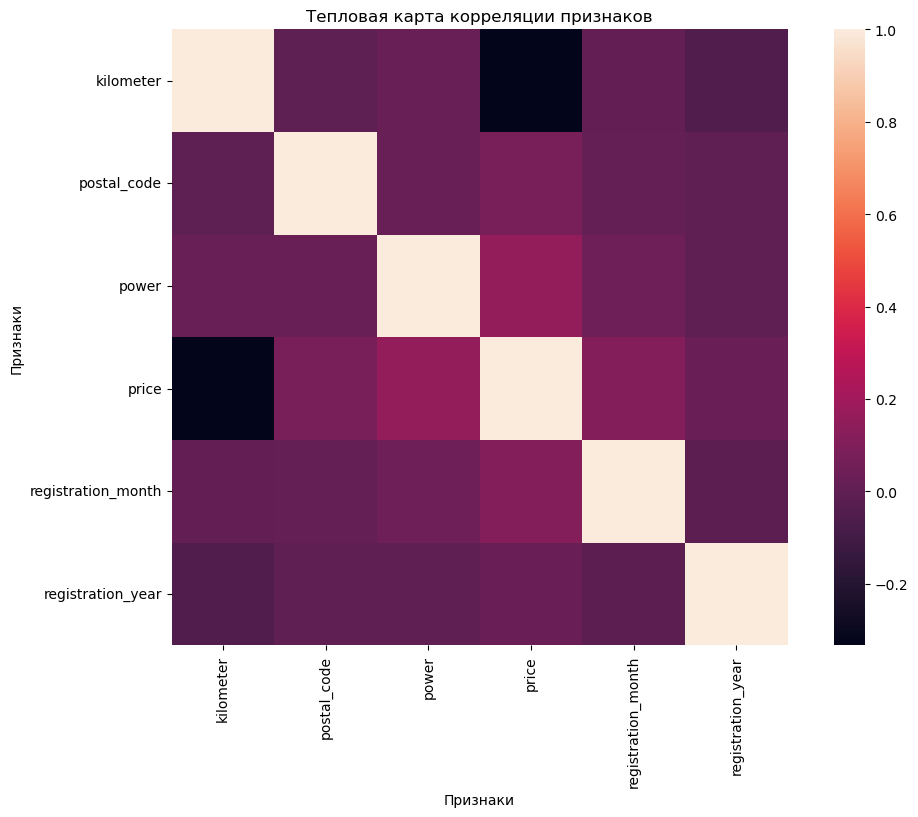

In [11]:
# Посмотрим на корреляцию признаков на тепловой карте
corrmat = df[df.columns.difference(['number_of_pictures'])].corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat,  square=True);
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.title("Тепловая карта корреляции признаков") ;

Корреляция между колличественными признаками околонулевая. Есть слабая обратная зависимость между ценой и пробегом, что вполне логично.

In [12]:
# Удалим признаки не влияющие на целевой признак
df = df.drop(['date_crawled','last_seen', 'registration_month', 'number_of_pictures', 'postal_code'], axis=1)

In [13]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print()
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
        print('Пустые ячейки столбца', column)
        print(data_frame[column].isnull().sum())
        print()
        #print(data_frame[column].value_counts())
    print('Количество пропусков в каждом столбце')    
    print(data_frame.isna().mean())
    print()
    print('Дубликаты строк:', df.duplicated().sum())

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [14]:
show_rows(df)


Уникальные значения столбца price
[  480 18300  9800 ... 12395 18429 10985]
Пустые ячейки столбца price
0


Уникальные значения столбца vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Пустые ячейки столбца vehicle_type
37490


Уникальные значения столбца registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300

Множество аномальных значений в столбцах: год регистрации, цена, мощность двигателя. Их необходимо убрать. Также обнаружил странность, что при удалении столбца - 'date_crawled' появляется 13347 дубликатов строк. Учитывая, что столбец переводится как "Дата скачивания анкеты из базы" в полне возможны задвоения.

In [15]:
# Дубликаты строк - удаление
df = df.drop_duplicates()

In [16]:
# Проверим сколько осталось строк
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340997 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              340997 non-null  int64         
 1   vehicle_type       304208 non-null  object        
 2   registration_year  340997 non-null  int64         
 3   gearbox            322128 non-null  object        
 4   power              340997 non-null  int64         
 5   model              321680 non-null  object        
 6   kilometer          340997 non-null  int64         
 7   fuel_type          308681 non-null  object        
 8   brand              340997 non-null  object        
 9   repaired           271579 non-null  object        
 10  date_created       340997 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 31.2+ MB


Проверим столбцы в зоне риска неявных дубликатов.

In [17]:
sorted(df['brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

In [18]:
sorted(df['model'].astype(str).unique())        

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Дубли rangerover, range_rover

In [21]:
df['model'] = df['model'].astype(str)
df['model'] = df['model'].apply(lambda x: x.replace('rangerover', 'range_rover'))

In [23]:
sorted(df['model'].unique())   

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Неявных дубликатов в марках и моделях больше не обнаружил.

Теперь удалим, аномальные значения.

In [24]:
# Отфильтровали по году регистрации
df = df.query('registration_year  >= 1915 & registration_year < 2017')

In [25]:
# Проверили
len(df[(df['registration_year'] > 2017) ].index)

0

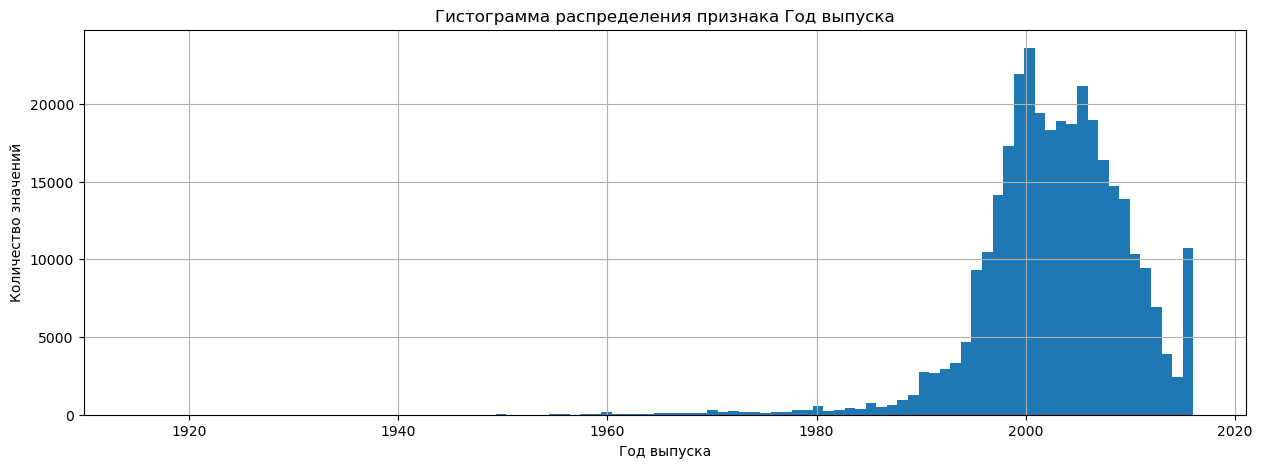

In [26]:
# Гистограмма распределения
df['registration_year'].hist(figsize=(15,5), bins=100)
plt.title('Гистограмма распределения признака Год выпуска')
plt.xlabel("Год выпуска")
plt.ylabel("Количество значений");

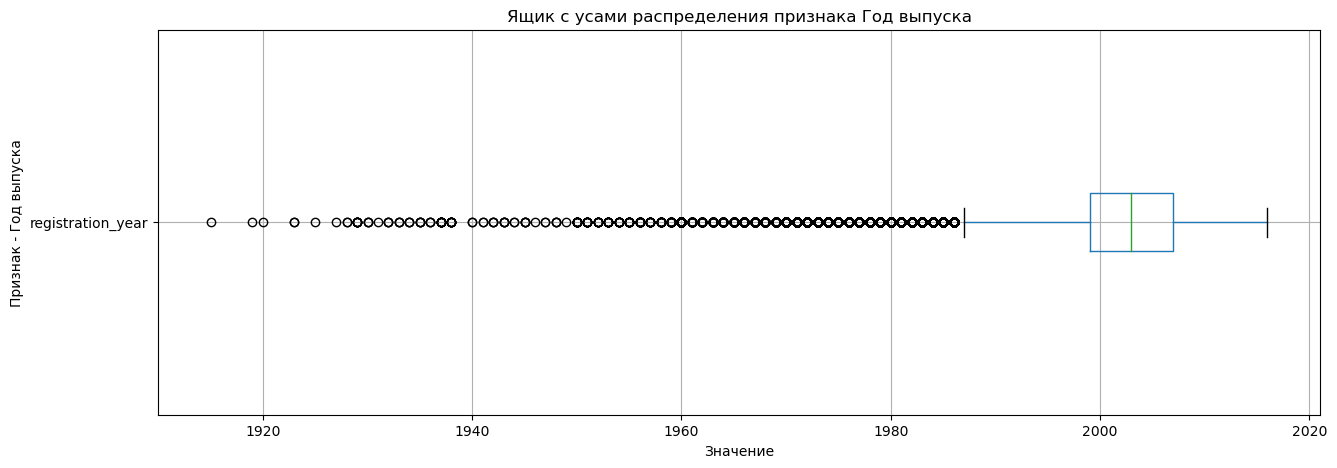

In [27]:
# Ящик с усами распределения
df.boxplot(column = ['registration_year'], figsize=(15,5), vert=False)
plt.title('Ящик с усами распределения признака Год выпуска')
plt.xlabel("Значение")
plt.ylabel("Признак - Год выпуска");

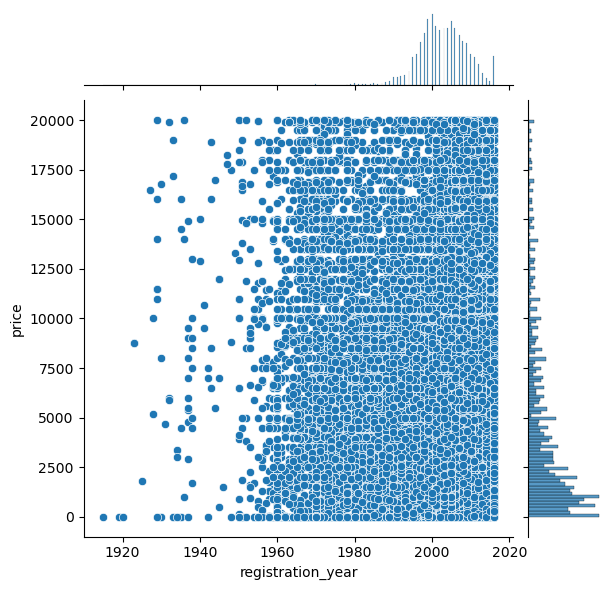

In [28]:
# Посмотрим на выбросы и как они соотносятся с целевым признаком
sns.jointplot(data=df, x='registration_year', y='price', hue=None, kind='scatter', height=6, ratio=5,\
              space=0.2, dropna=False, xlim=None, ylim=None, color=None, palette=None, hue_order=None,\
              hue_norm=None, marginal_ticks=False, joint_kws=None, marginal_kws=None);

In [29]:
# Отфильтровали по цене
df = df[(df['price'] > 100)]

In [30]:
# Проверили
len(df[(df['price'] < 100)].index)

0

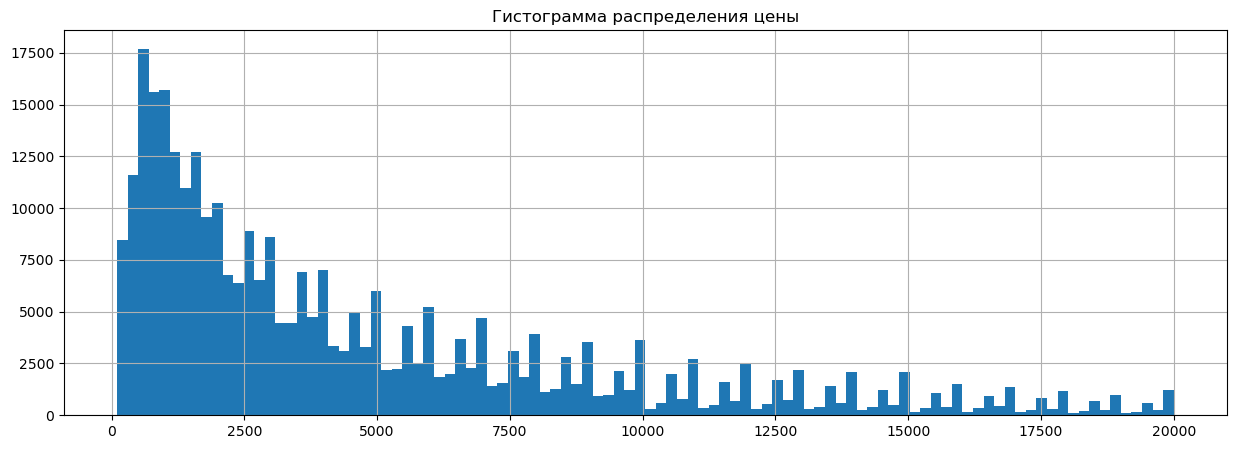

In [31]:
# Гистограмма распределения
df['price'].hist(figsize=(15,5), bins=100)
plt.title('Гистограмма распределения цены');

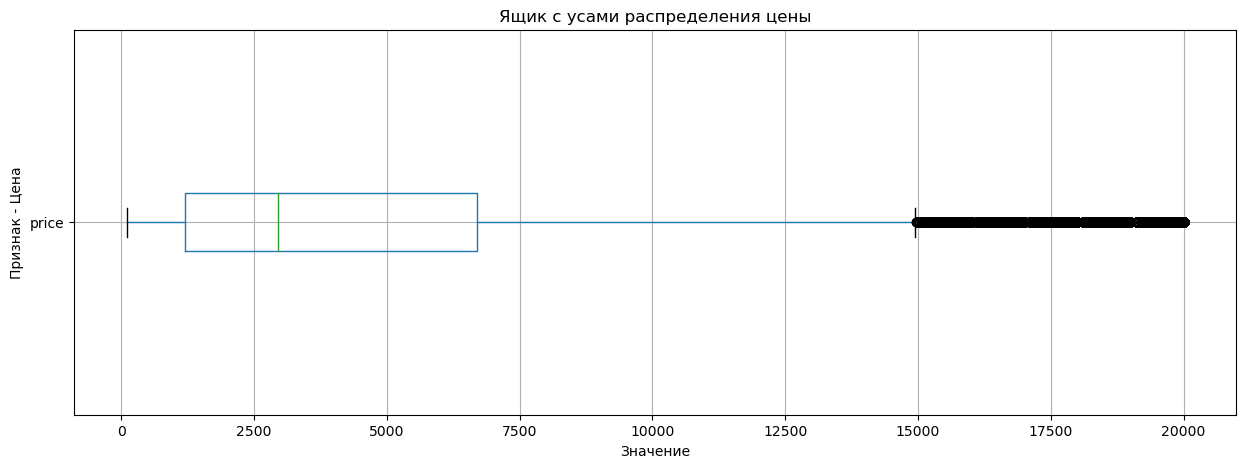

In [32]:
# Ящик с усами распределения
df.boxplot(column = ['price'], figsize=(15,5), vert=False)
plt.title('Ящик с усами распределения цены')
plt.xlabel("Значение")
plt.ylabel("Признак - Цена");

Максимальную границу цены устанавливать не будем.

In [33]:
# Отфильтровали по мощности
df = df[(df['power'] > 10) & (df['power'] < 1500)]

In [34]:
# Проверили
len(df[(df['power'] < 10) & (df['power'] < 10)].index)

0

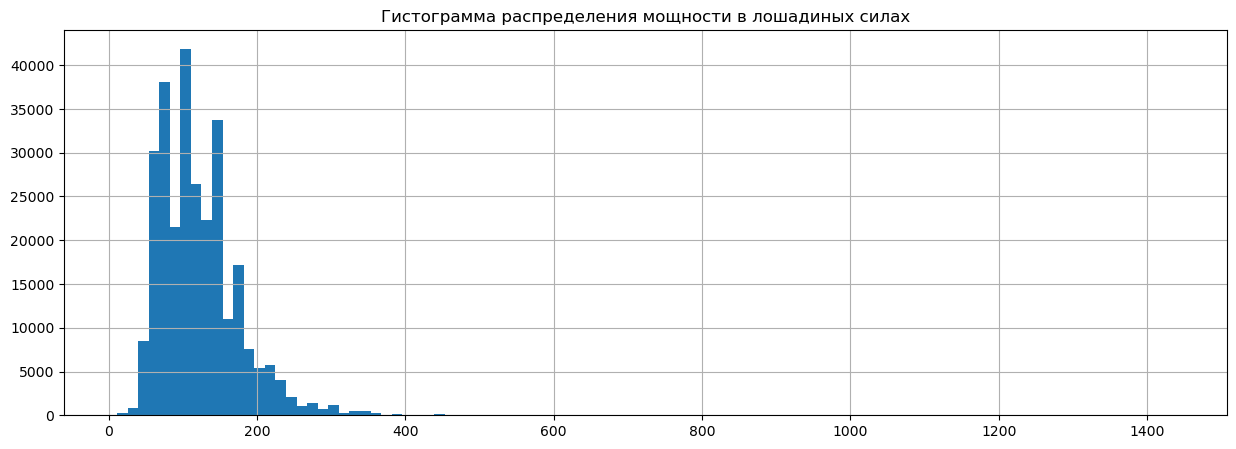

In [35]:
# Гистограмма распределения
df['power'].hist(figsize=(15,5), bins=100)
plt.title('Гистограмма распределения мощности в лошадиных силах');

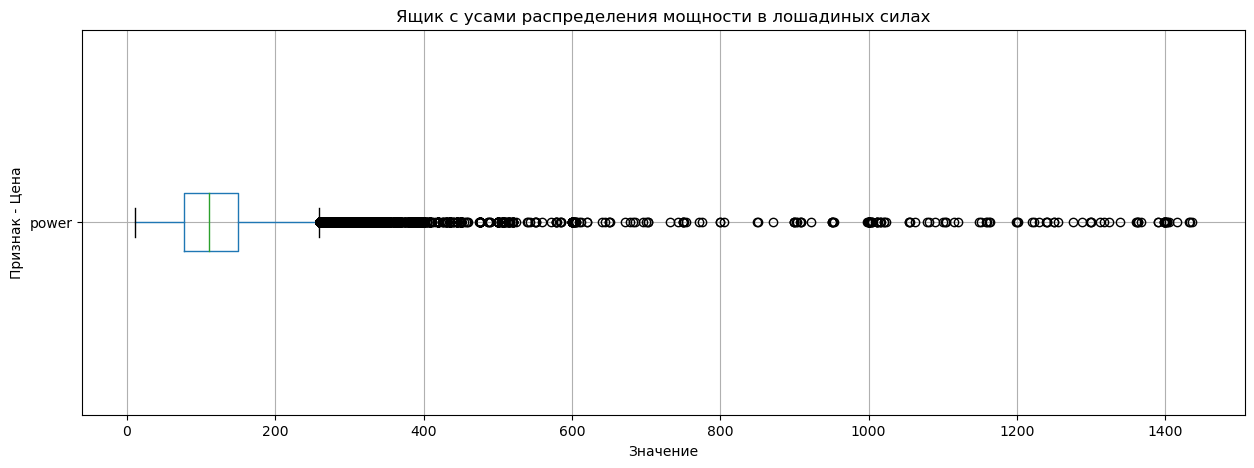

In [36]:
# Ящик с усами распределения
df.boxplot(column = ['power'], figsize=(15,5), vert=False)
plt.title('Ящик с усами распределения мощности в лошадиных силах')
plt.xlabel("Значение")
plt.ylabel("Признак - Цена");

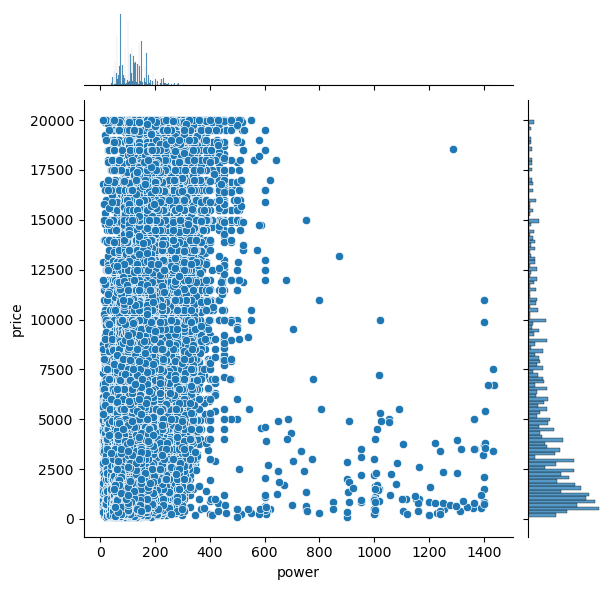

In [37]:
# Посмотрим на выбросы и как они соотносятся с целевым признаком
sns.jointplot(data=df, x='power', y='price', hue=None, kind='scatter', height=6, ratio=5,\
              space=0.2, dropna=False, xlim=None, ylim=None, color=None, palette=None, hue_order=None,\
              hue_norm=None, marginal_ticks=False, joint_kws=None, marginal_kws=None);

In [39]:
# заполним пропуски признака тип кузова
f = lambda x: x.value_counts().idxmax()
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby(df['model'].fillna('SPECIAL_MISSING'))['vehicle_type'].transform(f))

In [40]:
# заполним пропуски признака тип кузова
df['fuel_type'] = df['fuel_type'].fillna(df.groupby(df['model'].fillna('SPECIAL_MISSING'))['fuel_type'].transform(f))

In [42]:
# заполним пропуски признака тип кузова
df['gearbox'] = df['gearbox'].fillna(df.groupby(df['model'].fillna('SPECIAL_MISSING'))['gearbox'].transform(f))

In [44]:
# Изменим тип данных с object на category
object_to_str = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
df[object_to_str] = df[object_to_str].astype('category')

In [46]:
# Проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283152 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              283152 non-null  int64         
 1   vehicle_type       283152 non-null  category      
 2   registration_year  283152 non-null  int64         
 3   gearbox            283152 non-null  category      
 4   power              283152 non-null  int64         
 5   model              283152 non-null  category      
 6   kilometer          283152 non-null  int64         
 7   fuel_type          283152 non-null  category      
 8   brand              283152 non-null  category      
 9   repaired           241722 non-null  category      
 10  date_created       283152 non-null  datetime64[ns]
dtypes: category(6), datetime64[ns](1), int64(4)
memory usage: 14.9 MB


Пустые ячейки заполним где возможно, а остальные строки удалим. Возникла идея заполнить пропуски моделями, но по времени она трудозатратна. В интернете нашел, что уже подобное практикуется. Если останется время, сделаю второй вариант и сравню результаты.

In [47]:
# Еще раз проверим пропуски
df.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
repaired             41430
date_created             0
dtype: int64

In [48]:
print('Медианная стоимость невосстановленных машин', df['price'].loc[df['repaired'] == 'no'].median())
print()
print('Медианная стоимость восстановленных машин', df['price'].loc[df['repaired'] == 'yes'].median())

Медианная стоимость невосстановленных машин 3950.0

Медианная стоимость восстановленных машин 1100.0


Удалить столбец repaired не получится, тут явно содержится весомый признак. Попробуем его восстановить предсказаниями модели.

In [49]:
# Удалим последний столбец с датами 
# Удалим признаки не влияющие на целевой признак (распределение по годам здесь в основном 2016 год, изменение цен во времени не ухватим)
df = df.drop(['date_created'], axis=1)

In [50]:
# Посмотрим общую информацию о том, что осталось.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283152 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              283152 non-null  int64   
 1   vehicle_type       283152 non-null  category
 2   registration_year  283152 non-null  int64   
 3   gearbox            283152 non-null  category
 4   power              283152 non-null  int64   
 5   model              283152 non-null  category
 6   kilometer          283152 non-null  int64   
 7   fuel_type          283152 non-null  category
 8   brand              283152 non-null  category
 9   repaired           241722 non-null  category
dtypes: category(6), int64(4)
memory usage: 12.7 MB


In [51]:
# Удалим строки с моделями т.к. их много и предсказания будут не точны.
index = df.loc[df['model'].isna()].index
df.drop(index, inplace=True) # далее удаляем строки по их индексу

In [52]:
# Разделим Датафрейм на выборки 
drop_repaired_index = df[df['repaired'].isna()].index
# Выборка по которой будем предсказывать
df_isnull_repaired = df[df['repaired'].isna()]
df_whithout_isnull_repaired = df.copy()
df_whithout_isnull_repaired.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283152 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              283152 non-null  int64   
 1   vehicle_type       283152 non-null  category
 2   registration_year  283152 non-null  int64   
 3   gearbox            283152 non-null  category
 4   power              283152 non-null  int64   
 5   model              283152 non-null  category
 6   kilometer          283152 non-null  int64   
 7   fuel_type          283152 non-null  category
 8   brand              283152 non-null  category
 9   repaired           241722 non-null  category
dtypes: category(6), int64(4)
memory usage: 12.7 MB


In [53]:
# Сформируем обучающую выборку
df_whithout_isnull_repaired.drop(drop_repaired_index, inplace=True)
df_whithout_isnull_repaired.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241722 entries, 1 to 354367
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              241722 non-null  int64   
 1   vehicle_type       241722 non-null  category
 2   registration_year  241722 non-null  int64   
 3   gearbox            241722 non-null  category
 4   power              241722 non-null  int64   
 5   model              241722 non-null  category
 6   kilometer          241722 non-null  int64   
 7   fuel_type          241722 non-null  category
 8   brand              241722 non-null  category
 9   repaired           241722 non-null  category
dtypes: category(6), int64(4)
memory usage: 10.8 MB


In [54]:
# Заполним пропущенное значение предсказаниями модели градиентного бустинга, т.к. там бинарная классификация,
# и в принципе по цене и модели можно предположить восстановлена машина или нет
features_train_repaired = df_whithout_isnull_repaired.drop(['repaired'], axis=1)
target_train_repaired = df_whithout_isnull_repaired['repaired']
# ДатаФрейм с пропусками в столбце 'repaired' 
features_isnull_repaired = df_isnull_repaired.drop(['repaired'], axis=1)

In [56]:
%%time
# Запустим модель CatBoostClassifier, судя по описанию и функционалу всеядная штука
from catboost import CatBoostClassifier

cat_features = ['gearbox', 'model', 'brand', 'fuel_type', 'vehicle_type']
# Построим модель CatBoostClassifier

model = CatBoostClassifier(iterations=150, depth=16, learning_rate=0.6) 

model.fit(features_train_repaired, target_train_repaired, cat_features=cat_features, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4129966	total: 967ms	remaining: 2m 24s
10:	learn: 0.2601683	total: 7.44s	remaining: 1m 34s
20:	learn: 0.2476034	total: 12.9s	remaining: 1m 19s
30:	learn: 0.2339408	total: 20.7s	remaining: 1m 19s
40:	learn: 0.2242306	total: 28s	remaining: 1m 14s
50:	learn: 0.2156994	total: 35.4s	remaining: 1m 8s
60:	learn: 0.2097100	total: 42.7s	remaining: 1m 2s
70:	learn: 0.2045963	total: 49.8s	remaining: 55.4s
80:	learn: 0.1980607	total: 57s	remaining: 48.5s
90:	learn: 0.1933156	total: 1m 4s	remaining: 41.7s
100:	learn: 0.1885660	total: 1m 11s	remaining: 34.8s
110:	learn: 0.1844210	total: 1m 19s	remaining: 27.8s
120:	learn: 0.1812413	total: 1m 26s	remaining: 20.8s
130:	learn: 0.1778715	total: 1m 33s	remaining: 13.6s
140:	learn: 0.1750237	total: 1m 40s	remaining: 6.45s
149:	learn: 0.1716306	total: 1m 47s	remaining: 0us
CPU times: total: 2min 45s
Wall time: 1min 48s


In [57]:
# Построим предсказание на валидационной выборке
df_isnull_repaired['repaired'] = model.predict(features_isnull_repaired)


C:\Users\ipd08\AppData\Local\Temp\ipykernel_2184\679640511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_isnull_repaired['repaired'] = model.predict(features_isnull_repaired)


In [58]:
df_isnull_repaired.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,no
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,no
16,300,small,2016,manual,60,polo,150000,petrol,volkswagen,yes


In [60]:
print('Медианная стоимость невосстановленных машин', df_isnull_repaired['price'].loc[df_isnull_repaired['repaired'] == 'no'].median())
print()
print('Медианная стоимость восстановленных машин', df_isnull_repaired['price'].loc[df_isnull_repaired['repaired'] == 'yes'].median())

Медианная стоимость невосстановленных машин 2100.0

Медианная стоимость восстановленных машин 400.0


In [61]:
# Объеденим датафреймы в новый датафрейм
df_new = pd.concat([df_whithout_isnull_repaired, df_isnull_repaired], axis=0)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283152 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              283152 non-null  int64   
 1   vehicle_type       283152 non-null  category
 2   registration_year  283152 non-null  int64   
 3   gearbox            283152 non-null  category
 4   power              283152 non-null  int64   
 5   model              283152 non-null  category
 6   kilometer          283152 non-null  int64   
 7   fuel_type          283152 non-null  category
 8   brand              283152 non-null  category
 9   repaired           283152 non-null  object  
dtypes: category(5), int64(4), object(1)
memory usage: 14.6+ MB


In [62]:
df_new.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,nan,125000,gasoline,audi,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [63]:
# Посмотрим общую информацию о том, что осталось.
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283152 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              283152 non-null  int64   
 1   vehicle_type       283152 non-null  category
 2   registration_year  283152 non-null  int64   
 3   gearbox            283152 non-null  category
 4   power              283152 non-null  int64   
 5   model              283152 non-null  category
 6   kilometer          283152 non-null  int64   
 7   fuel_type          283152 non-null  category
 8   brand              283152 non-null  category
 9   repaired           283152 non-null  object  
dtypes: category(5), int64(4), object(1)
memory usage: 14.6+ MB


In [65]:
# Изменим тип столбца
df_new['repaired'] = df_new['repaired'].astype('category')

Посмотрим на количественное распределение категорий признаков.

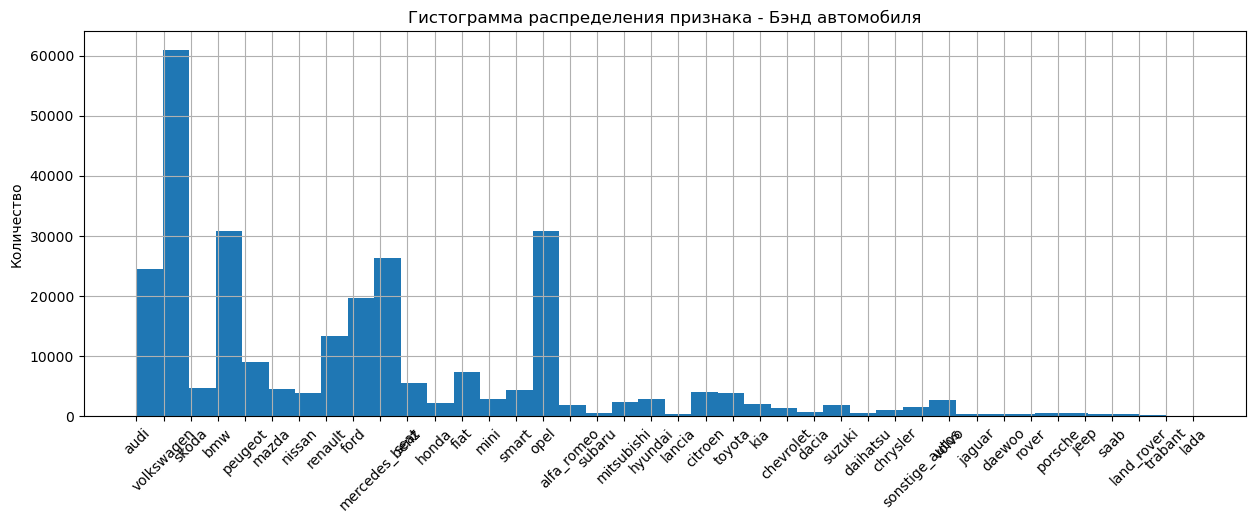

In [66]:
# Гистограмма распределения
df_new['brand'].hist(figsize=(15,5), bins=40)
plt.xticks(rotation=45)
plt.ylabel('Количество')
plt.title('Гистограмма распределения признака - Бэнд автомобиля');

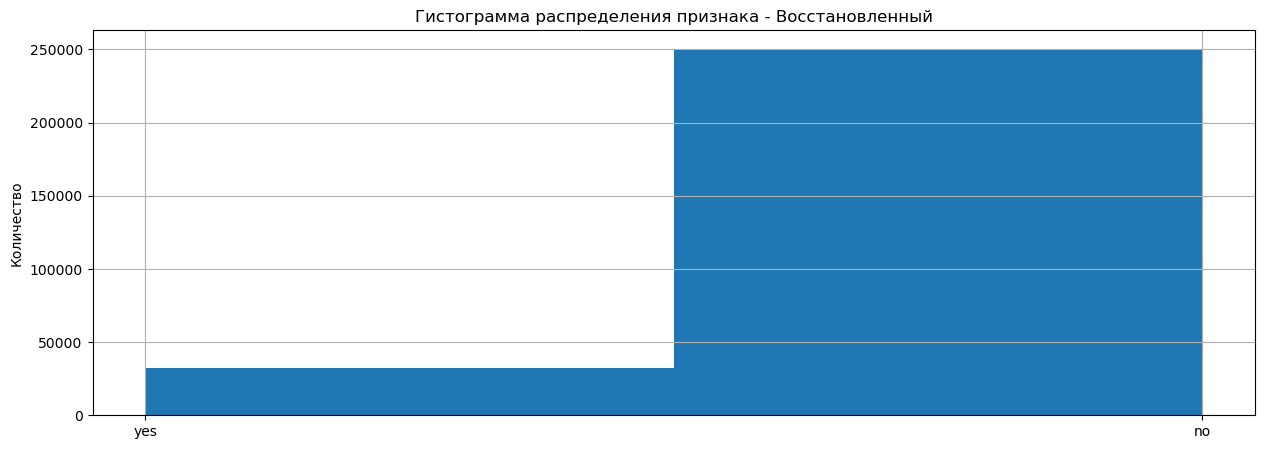

In [67]:
# Гистограмма распределения
df_new['repaired'].hist(figsize=(15,5), bins=2)
plt.ylabel('Количество')
plt.title('Гистограмма распределения признака - Восстановленный');

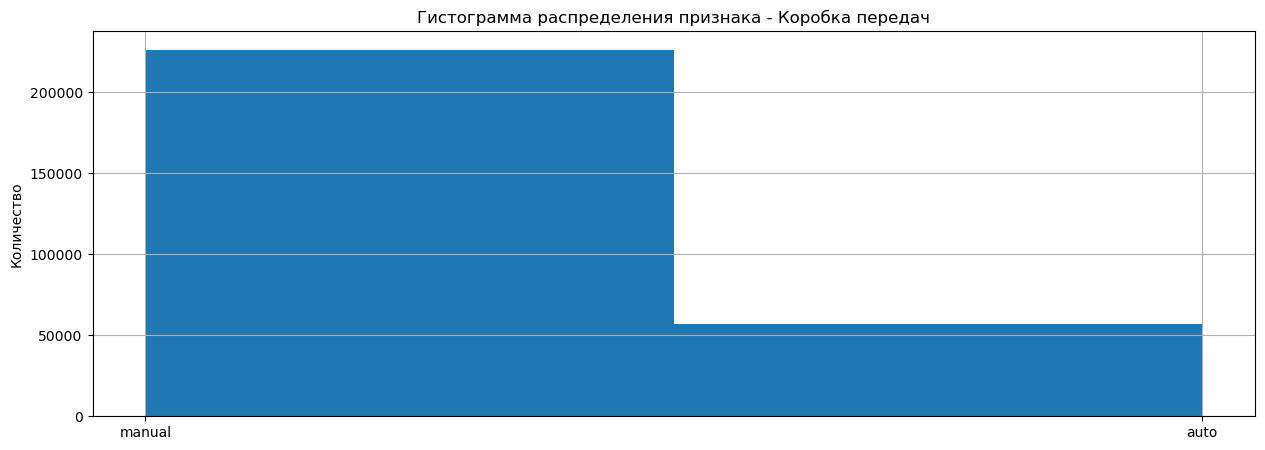

In [68]:
# Гистограмма распределения
df_new['gearbox'].hist(figsize=(15,5), bins=2)
plt.ylabel('Количество')
plt.title('Гистограмма распределения признака - Коробка передач');

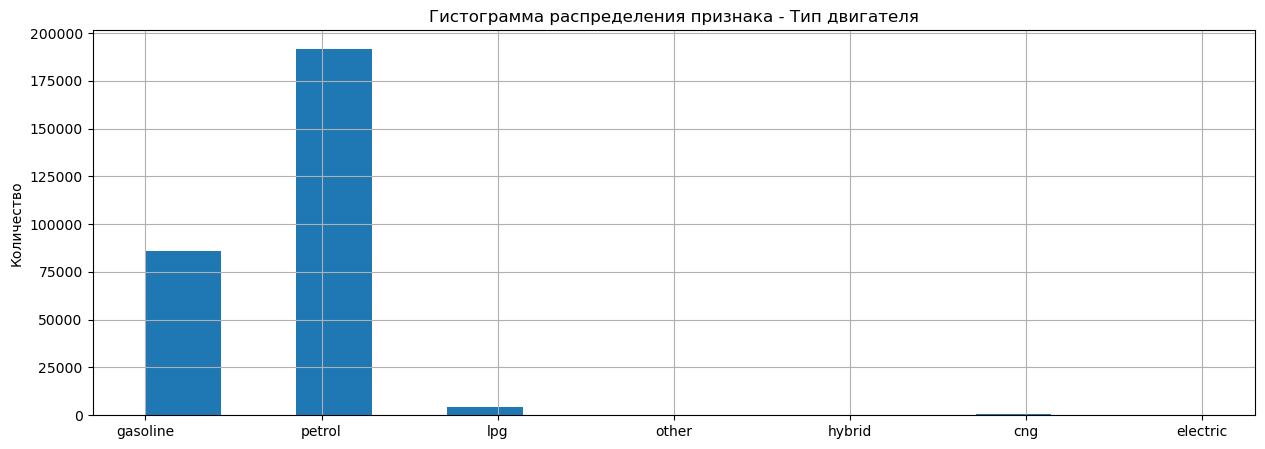

In [70]:
# Гистограмма распределения
df_new['fuel_type'].hist(figsize=(15,5), bins=14)
plt.ylabel('Количество')
plt.title('Гистограмма распределения признака - Тип двигателя');

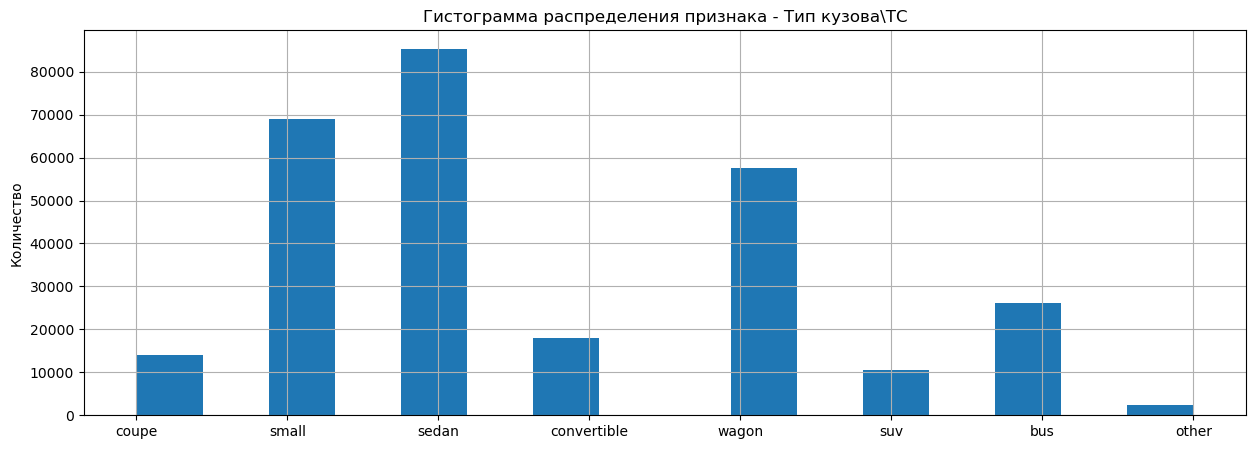

In [71]:
# Гистограмма распределения
df_new['vehicle_type'].hist(figsize=(15,5), bins=16)
plt.ylabel('Количество')
plt.title('Гистограмма распределения признака - Тип кузова\ТС');

In [72]:
# Функция по преобразованию
def convert_to_gasoline(df):
    try:
        if df == 'petrol':
            return 'gasoline'
        else:
            return df
    except:
        print('Ошибка')

In [74]:
# Сформируем обновленный признак
df_new['fueltype_new'] = df_new['fuel_type'].apply(convert_to_gasoline)

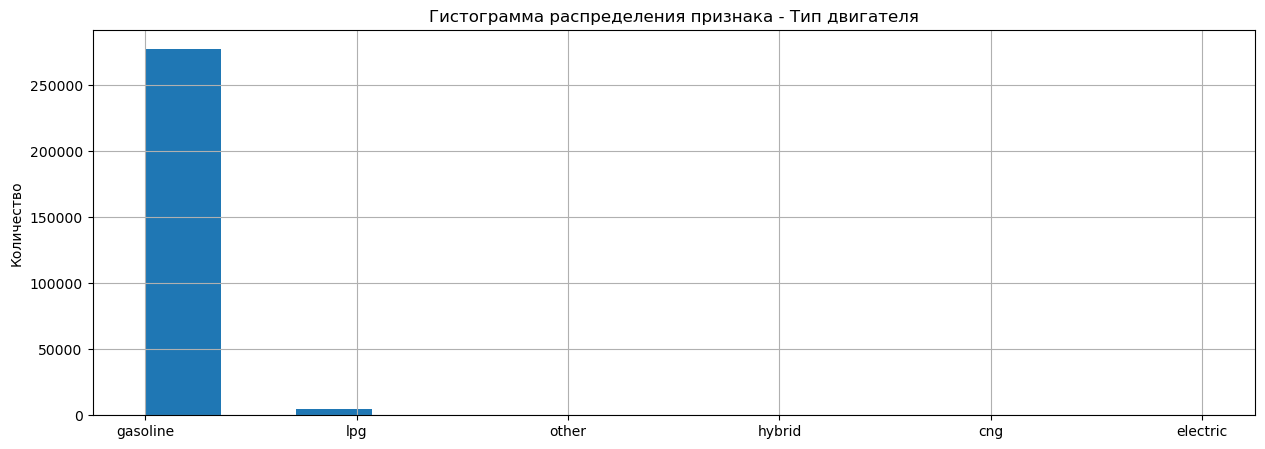

In [75]:
# Гистограмма распределения обновленного признака
df_new['fueltype_new'].hist(figsize=(15,5), bins=14)
plt.ylabel('Количество')
plt.title('Гистограмма распределения признака - Тип двигателя');

In [76]:
# Удалим старый столбец
df_new = df_new.drop(['fuel_type'], axis=1)


In [77]:
# Изменим тип столбца
df_new['fueltype_new'] = df_new['fueltype_new'].astype('category')

In [78]:
# Проверим
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283152 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              283152 non-null  int64   
 1   vehicle_type       283152 non-null  category
 2   registration_year  283152 non-null  int64   
 3   gearbox            283152 non-null  category
 4   power              283152 non-null  int64   
 5   model              283152 non-null  category
 6   kilometer          283152 non-null  int64   
 7   brand              283152 non-null  category
 8   repaired           283152 non-null  category
 9   fueltype_new       283152 non-null  category
dtypes: category(6), int64(4)
memory usage: 12.7 MB


### Выводы по результатам предобработки данных
<p>Корреляция между колличественными признаками околонулевая. Есть слабая обратная зависимость между ценой и пробегом, что вполне логично.</p>
<p>Множество аномальных значений в столбцах: год регистрации, цена, мощность двигателя. Их удалили. Также обнаружил странность, что при удалении столбца - 'datecrawled' появляется 13347 дубликатов строк. Учитывая, что столбец переводится как "Дата скачивания анкеты из базы" в полне возможны задвоения.</p>
<p>Удалил строки с пустыми ячейками, анамальными значениями и полные дубликаты. Неявные дубликаты в марках и моделях не выявлено.</p>
<p>Заполнил пустые ячейки наиболее частовстречаемыми значениями на основе группировки данных из других столбцов.</p>
<p>Также удалил столбцы с датами, с информацией о количестве фотографий, месяцем регистрации и почтовым индексом. Можно было удалить столбец с типом кузова, но некторые модели имеют разные типы кузовов, т.е. нет четкой привязки модель - один вариант кузова. Универсалы и купе стоят дороже седанов, как пример.</p>
<p>В количественных признаках много выбросов, но эти выбросы характеризуют вероятно раритеные и не стандартные автомобили.</p>
<p>При изучении данных по верхам, видно преимуществнное преобладание немецких автомобилей в ДатаФрейме, автомоблилей с механической трансмиссией в 3 раза больше, чем с автоматической. Невосстановленных машин более чем в 7 раз больше, чем восстановленных. Кроме того, медианная стоимость невосстановленных машин = 3990.0, а медианная стоимость восстановленных машин 1100.0. Удалить столбец repaired не получится, тут явно содержится весомый признак. </p>
<p>Есть странность в типе двигателя gasoline и petrol - бензин в разных страннах обозначается по разному, целесобразно объеденить, lpg и cng - разновидности газа, количество маленькое, трогать не будем.</p>
<p>Самыми распространенными типами кузова являются Седан, хэчбэк и универсал. </p>

## Обучение моделей

In [79]:
# Разделим данный и выделим целевой признак от остальных признаков
features = df_new.drop(['price'], axis=1)
target = df_new['price']

In [80]:
# Сформируем выборки для обучения и тестирования моделей
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [81]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [82]:
# Стандартизируем данные
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_ohe = scaler.transform(features_train_ohe)

scaler = StandardScaler()
scaler.fit(features_valid_ohe)
features_valid_ohe = scaler.transform(features_valid_ohe)

scaler = StandardScaler()
scaler.fit(features_test_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

### Проверим работу Линейной регрессии 

In [83]:
%%time
# Посмотрим как работает модель логистической регрессии
# Обучение 
model = LinearRegression()
model = model.fit(features_train_ohe, target_train)

CPU times: total: 3.73 s
Wall time: 1.4 s


In [84]:
%%time
# Предсказание 
predictions = model.predict(features_valid_ohe)
result_lr = mean_squared_error(target_valid, predictions)**0.5
print("Посмотрим метрику качества RMSE", result_lr)

Посмотрим метрику качества RMSE 2715.4353768708042
CPU times: total: 31.2 ms
Wall time: 22.9 ms


Проверим работу модели Стохастического градиентного спуска с регуляризацией

In [85]:
%%time
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
                # копируем вектор w, чтобы его не менять
                reg = 2 * w.copy()
                reg[0] = 0
                gradient += self.reg_weight * reg
                
                w -= self.step_size * gradient

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

# Обучение 
model = SGDLinearRegression(0.1, 5, 50000, 0)
model.fit(features_train_ohe, target_train)


CPU times: total: 391 ms
Wall time: 1.16 s


In [86]:
%%time
# Предсказание
pred_valid = model.predict(features_valid_ohe)
rmse_SGDL_1 = mean_squared_error(target_valid, pred_valid)**0.5

print("RMSE:", rmse_SGDL_1)

RMSE: 2741.177852884315
CPU times: total: 0 ns
Wall time: 3 ms


Скорость обучения увеличилась!

In [87]:
model = SGDLinearRegression(0.1, 5, 50000, 0.1)
model.fit(features_train_ohe, target_train)

pred_valid = model.predict(features_valid_ohe)
rmse_SGDL = mean_squared_error(target_valid, pred_valid)**0.5

print("RMSE:", rmse_SGDL)

model = SGDLinearRegression(0.1, 5, 50000, 1)
model.fit(features_train_ohe, target_train)

pred_valid = model.predict(features_valid_ohe)
rmse_SGDL = mean_squared_error(target_valid, pred_valid)**0.5

print("RMSE:", rmse_SGDL)

model = SGDLinearRegression(0.1, 5, 50000, 5)
model.fit(features_train_ohe, target_train)

pred_valid = model.predict(features_valid_ohe)
rmse_SGDL = mean_squared_error(target_valid, pred_valid)**0.5

print("RMSE:", rmse_SGDL)


RMSE: 2757.88725953297
RMSE: 3097.5981606175906
RMSE: 3880.9412305353917


In [89]:
%%time
# Посмотрим на работу модели из библиотеки sklearn.linear_model - SGDRegressor

from sklearn.linear_model import SGDRegressor
from sklearn import linear_model

model = linear_model.SGDRegressor(loss='squared_error', penalty='l2', random_state=12345)
model.fit(features_train_ohe, target_train)

y_predicted = model.predict(features_valid_ohe)
rmse_SGDRegressor = (mean_squared_error(target_valid, y_predicted)**0.5).round(5)
print("RMSE sklearn.linear_model - SGDRegressor:", rmse_SGDRegressor)

RMSE sklearn.linear_model - SGDRegressor: 40931840721.48548
CPU times: total: 9.64 s
Wall time: 32.2 s


### Модель Случайного леса

In [91]:
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['gearbox', 'model', 'brand', 'repaired','fueltype_new', 'vehicle_type']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [92]:
%%time
# Посмотрим как работает модель случайный лес и как влияют гиперпараметры
best_model = None
best_result_rfc = 3000
for est in tqdm(range(1, 25, 5)):
    for depth in range(1, 25, 5):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train_ord, target_train) 
        predictions = model.predict(features_valid_ord)
        result = (mean_squared_error(target_valid, predictions))**0.5
        if result < best_result_rfc:
            best_model = model
            best_result_rfc = result
            best_estimator_rfc = est
            best_depth_rfc = depth
print("RMSE наилучшей модели на валидационной выборке:", best_result_rfc,\
      ", лучший эстиматор-гиперпараметр", best_estimator_rfc, ", лучшая глубина-гиперпараметр", best_depth_rfc)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.55s/it]

RMSE наилучшей модели на валидационной выборке: 1607.1249883373264 , лучший эстиматор-гиперпараметр 21 , лучшая глубина-гиперпараметр 21
CPU times: total: 14 s
Wall time: 37.8 s


In [93]:
%%time
predictions = model.predict(features_valid_ord)
result = (mean_squared_error(target_valid, predictions))**0.5
print("RMSE наилучшей модели на валидационной выборке:", result)

RMSE наилучшей модели на валидационной выборке: 1607.1249883373264
CPU times: total: 172 ms
Wall time: 247 ms


### Посмотрим на работу CatBoostRegressor

In [95]:
%%time
# Заново сформируем выборки, т.к. модель самостоятельно обрабатывает категориальные признаки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
   df_new.drop(['price'], axis=1), df_new.price, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

cat_features = ['gearbox', 'model', 'brand', 'repaired','fueltype_new', 'vehicle_type']
# Построим модель CatBoostRegressor

model = CatBoostRegressor(loss_function="RMSE", iterations=150, depth=8, learning_rate=0.6) 

model.fit(features_train, target_train, cat_features=cat_features, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2959.0439635	total: 45ms	remaining: 6.7s
10:	learn: 1790.2747648	total: 429ms	remaining: 5.42s
20:	learn: 1709.6271473	total: 798ms	remaining: 4.9s
30:	learn: 1665.3422123	total: 1.17s	remaining: 4.5s
40:	learn: 1626.0910971	total: 1.54s	remaining: 4.11s
50:	learn: 1599.1484390	total: 1.91s	remaining: 3.71s
60:	learn: 1576.2842371	total: 2.29s	remaining: 3.34s
70:	learn: 1555.5356822	total: 2.67s	remaining: 2.97s
80:	learn: 1535.7998753	total: 3.07s	remaining: 2.62s
90:	learn: 1523.8677547	total: 3.5s	remaining: 2.27s
100:	learn: 1510.9636325	total: 3.86s	remaining: 1.87s
110:	learn: 1497.9639760	total: 4.22s	remaining: 1.48s
120:	learn: 1489.1733799	total: 4.59s	remaining: 1.1s
130:	learn: 1481.1829926	total: 4.95s	remaining: 718ms
140:	learn: 1472.7380541	total: 5.31s	remaining: 339ms
149:	learn: 1467.1032998	total: 5.64s	remaining: 0us
CPU times: total: 3.78 s
Wall time: 5.84 s


In [96]:
%%time
# Построим предсказание на валидационной выборке
probabilities_valid = model.predict(features_valid)
rmse_CatBoostRegressor = mean_squared_error(target_valid, probabilities_valid)**0.5
print("RMSE модели CatBoostRegressor", rmse_CatBoostRegressor)

RMSE модели CatBoostRegressor 1597.9159611656444
CPU times: total: 15.6 ms
Wall time: 34.1 ms


### Посмотрим на работу LightGBM

In [106]:
%%time
# Построим модель LGBMRegressor
# Обучение 
model = lgb.LGBMRegressor()
model.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 169891, number of used features: 9
[LightGBM] [Info] Start training from score 4861.649911
CPU times: total: 4 s
Wall time: 237 ms


LGBMRegressor()

In [108]:
%%time
# Предсказание
y_pred = model.predict(features_valid)
rmse_LGBMRegressor = mean_squared_error(target_valid, y_pred)**0.5
print("RMSE модели LGBMRegressor", rmse_LGBMRegressor)

RMSE модели LGBMRegressor 1605.4887132250785
CPU times: total: 594 ms
Wall time: 46 ms


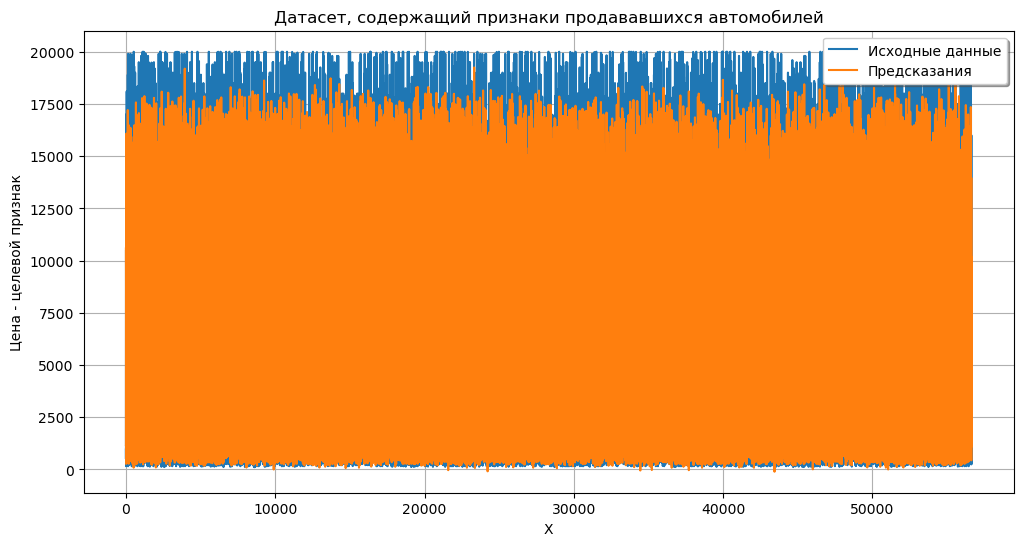

Text(0.5, 1.0, 'Важные признаки')

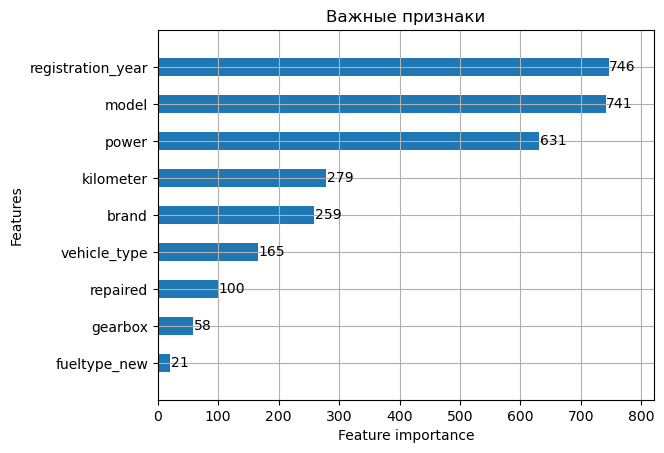

In [109]:
# Визуализаця предсказаний и ответов
x_ax = range(len(target_valid))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, target_valid, label="Исходные данные")
plt.plot(x_ax, y_pred, label="Предсказания")
plt.title("Датасет, содержащий признаки продававшихся автомобилей")
plt.xlabel('X')
plt.ylabel('Цена - целевой признак')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

# Важные признаки
lgb.plot_importance(model, height=.5) 
plt.title("Важные признаки")
 

### Выводы по результатам обучения моделей
Построил модели:
- Линейной регрессии;
- Линейной Регрессии со стахостическим градиентным спуском;
- Случайный лес;
- Градиентный бустинг LGBM и CatBoost.
<p>Градиентный бустинг показал лучший результат по качеству. 

## Анализ моделей

| Модель | Скорость обучения | Скорость предсказания | Показатель RMSE |
| --- | --- | --- | --- |
| Линейная регрессия | 26.7 s | 14.7 ms | 2715 |
| Линейная регрессия SGD | 5.65 s | 6.01 ms | 2722 |
| Случайный лес | 37.8 s | 247 ms | 1607 |
| CatBoost Regressor | 5.84 s | 34.1 ms | 1597 |
| LightGBM Regressor | 237 ms | 46 ms | 1605 |


<p>На основе полученных данных о результатах моделей я пришел к выводу, что градиентный бустинг показывает лучшие результаты по метрикам качества, однако уступает в скорости линейной регрессии со стахостическим градиентным спуском.</p> <p> Модель Случайного Леса также не стоит списывать со счетов - она показала очень близкий результат к бустингу и по скорости опережает LightGBM Regressor.</p>
<b><p>При этом модель на основе алгоритма от Яндекса - CatBoost показала лучшие результаты по скорости обучения, предсказания и качеству в совакупности.</b></p> <p> Бустинг - LightGBM показал значительное отставание в скорости, и не стабильный результат по скорости, время обучения очень часто меняется, что не скажешь о CatBoost и Случайном лесе.</p>
<p>Между скоростью обучения и предсказания присутствует линейная зависимость, чем модель быстрее модель выполняет алгоритм обучения, тем быстрее справляется с предсказанием.</p>

## Тестирование лучшей модели

In [110]:
%%time
# Проверим модель CatBoostRegressor
cat_features = ['gearbox', 'model', 'brand', 'repaired','fueltype_new', 'vehicle_type']

model = CatBoostRegressor(loss_function="RMSE", iterations=150, depth=8, learning_rate=0.6) 

model.fit(features_train, target_train, cat_features=cat_features, verbose=10)
y = model.predict(features_test)
rmse_CatBoostRegressor_test = mean_squared_error(target_test, y)**0.5

print("RMSE модели CatBoostRegressor на тестовой выборке", rmse_CatBoostRegressor)

0:	learn: 2959.0439635	total: 43.9ms	remaining: 6.55s
10:	learn: 1790.2747648	total: 438ms	remaining: 5.54s
20:	learn: 1709.6271473	total: 802ms	remaining: 4.93s
30:	learn: 1665.3422123	total: 1.19s	remaining: 4.56s
40:	learn: 1626.0910971	total: 1.56s	remaining: 4.15s
50:	learn: 1599.1484390	total: 1.93s	remaining: 3.74s
60:	learn: 1576.2842371	total: 2.29s	remaining: 3.34s
70:	learn: 1555.5356822	total: 2.66s	remaining: 2.96s
80:	learn: 1535.7998753	total: 3.02s	remaining: 2.58s
90:	learn: 1523.8677547	total: 3.39s	remaining: 2.19s
100:	learn: 1510.9636325	total: 3.75s	remaining: 1.82s
110:	learn: 1497.9639760	total: 4.12s	remaining: 1.45s
120:	learn: 1489.1733799	total: 4.48s	remaining: 1.07s
130:	learn: 1481.1829926	total: 4.84s	remaining: 702ms
140:	learn: 1472.7380541	total: 5.2s	remaining: 332ms
149:	learn: 1467.1032998	total: 5.53s	remaining: 0us
RMSE модели CatBoostRegressor на тестовой выборке 1597.9159611656444
CPU times: total: 4.02 s
Wall time: 5.72 s


## Итоговый вывод:
<p>Корреляция между колличественными признаками околонулевая. Есть слабая обратная зависимость между ценой и пробегом, что вполне логично.</p>
<p>Множество аномальных значений в столбцах: год регистрации, цена, мощность двигателя. Их удалили. Также обнаружил странность, что при удалении столбца - 'datecrawled' появляется 13347 дубликатов строк. Учитывая, что столбец переводится как "Дата скачивания анкеты из базы" в полне возможны задвоения.</p>
<p>Удалил строки с пустыми ячейками, анамальными значениями и полные дубликаты. Неявные дубликаты в марках и моделях удалены.</p>
<p>Заполнил пустые ячейки наиболее частовстречаемыми значениями на основе группировки данных из других столбцов.</p>
<p>Также удалил столбцы с датами, с информацией о количестве фотографий, месяцем регистрации и почтовым индексом. Можно было удалить столбец с типом кузова, но некторые модели имеют разные типы кузовов, т.е. нет четкой привязки модель - один вариант кузова. Универсалы и купе стоят дороже седанов, как пример.</p>
<p>В количественных признаках много выбросов, но эти выбросы характеризуют вероятно раритеные и не стандартные автомобили.</p>
<p>При изучении данных по верхам, видно преимуществнное преобладание немецких автомобилей в ДатаФрейме, автомоблилей с механической трансмиссией в 3 раза больше, чем с автоматической. Невосстановленных машин более чем в 7 раз больше, чем восстановленных. Кроме того, медианная стоимость невосстановленных машин = 3990.0, а медианная стоимость восстановленных машин 1100.0. Удалить столбец repaired не получится, тут явно содержится весомый признак. </p>
<p>Есть странность в типе двигателя gasoline и petrol - бензин в разных страннах обозначается по разному, целесобразно объеденить, lpg и cng - разновидности газа, количество маленькое, трогать не будем.</p>
<p>Самыми распространенными типами кузова являются Седан, хэчбэк и универсал. </p>

Построил модели:

| Модель | Скорость обучения | Скорость предсказания | Показатель RMSE |
| --- | --- | --- | --- |
| Линейная регрессия | 26.7 s | 14.7 ms | 2715 |
| Линейная регрессия SGD | 5.65 s | 6.01 ms | 2722 |
| Случайный лес | 37.8 s | 247 ms | 1607 |
| CatBoost Regressor | 5.84 s | 34.1 ms | 1597 |
| LightGBM Regressor | 237 ms | 46 ms | 1605 |

<p>На основе полученных данных о результатах моделей я пришел к выводу, что градиентный бустинг показывает лучшие результаты по метрикам качества, однако уступает в скорости линейной регрессии со стахостическим градиентным спуском.</p> <p> Модель Случайного Леса также не стоит списывать со счетов - она показала очень близкий результат к бустингу и по скорости опережает LightGBM Regressor.</p>
<b><p>При этом модель на основе алгоритма от Яндекса - CatBoost показала лучшие результаты по скорости обучения, предсказания и качеству в совакупности.</b></p> <p> Бустинг - LightGBM показал значительное отставание в скорости, и не стабильный результат по скорости, время обучения очень часто меняется, что не скажешь о CatBoost и Случайном лесе.</p>

<p>Градиентный бустинг от Яндекса - CatBoost показал лучший результат по качеству и скорости.</p>
<p>RMSE модели CatBoostRegressor на тестовой выборке 1597.9159611656444
<p>CPU times: total: 3.61 s
<p>Wall time: 6.09 s